Author: Andreas Traut  
Date: 14.04.2021  
Source: https://www.kaggle.com/garystafford/environmental-sensor-data-132k  
Licence: CC-BY-NC-SA, Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License  
This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License. To view a copy of this license, visit [http://creativecommons.org/licenses/by-nc-sa/4.0/](http://creativecommons.org/licenses/by-nc-sa/4.0/) or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

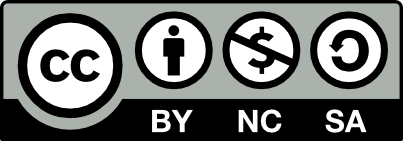

# Environmental Sensor Data

## Temperature, humidity, CO, liquid petroleum gas (LPG), smoke, light, and motion

### Content

The data was generated from a series of three identical, custom-built, breadboard-based sensor arrays. Each array was connected to a Raspberry Pi devices. Each of the three IoT devices was placed in a physical location with varied environmental conditions.

| device            | environmental conditions                 |
|-------------------|------------------------------------------|
| 00:0f:00:70:91:0a | stable conditions, cooler and more humid |
| 1c:bf:ce:15:ec:4d | highly variable temperature and humidity |
| b8:27:eb:bf:9d:51 | stable conditions, warmer and dryer      |

Each IoT device collected a total of seven different readings from the four sensors on a regular interval. Sensor readings include temperature, humidity, carbon monoxide (CO), liquid petroleum gas (LPG), smoke, light, and motion. The data spans the period from 07/12/2020 00:00:00 UTC – 07/19/2020 23:59:59 UTC. There is a total of 405,184 rows of data.

The sensor readings, along with a unique device ID and timestamp, were published as a single message, using the ISO standard Message Queuing Telemetry Transport (MQTT) network protocol. Below is an example of an MQTT message payload.

{
  "data": {
    "co": 0.006104480269226063,
    "humidity": 55.099998474121094,
    "light": true,
    "lpg": 0.008895956948783413,
    "motion": false,
    "smoke": 0.023978358312270912,
    "temp": 31.799999237060547
  },
  "device_id": "6e:81:c9:d4:9e:58",
  "ts": 1594419195.292461
}


### Structure

I will follow the structure of my Mind Map for Machine Learning. See by book "From Zero to Senior Data Scientist" for details. 

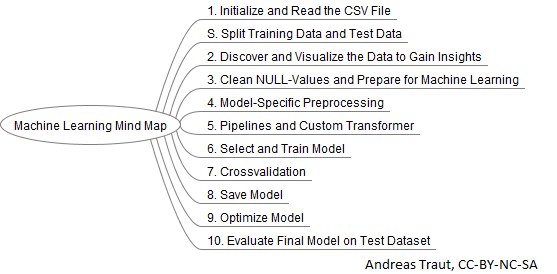

### 1. Initialize and Read the CSV File

In [1]:
import os
import sys
import pandas as pd
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [2]:
filelist = []
for directory, _, files in os.walk('.\input'):
    for file in files:        
        filelist.append(os.path.join(directory, file))           

In [3]:
filelist

['.\\input\\environmental-sensor-data-132k\\iot_telemetry_data.csv']

In [4]:
if len(filelist)==1: 
    file = filelist[0]

In [5]:
file

'.\\input\\environmental-sensor-data-132k\\iot_telemetry_data.csv'

In [6]:
def myDateConverter(x):
    return pd.to_datetime(x, infer_datetime_format=True, unit='s',utc=True)

In [7]:
df = pd.read_csv(file,
                 delimiter=',',                
                 header=0,
                 infer_datetime_format=True,
                 converters={'ts':myDateConverter})

#### Describe data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   ts        405184 non-null  datetime64[ns, UTC]
 1   device    405184 non-null  object             
 2   co        405184 non-null  float64            
 3   humidity  405184 non-null  float64            
 4   light     405184 non-null  bool               
 5   lpg       405184 non-null  float64            
 6   motion    405184 non-null  bool               
 7   smoke     405184 non-null  float64            
 8   temp      405184 non-null  float64            
dtypes: bool(2), datetime64[ns, UTC](1), float64(5), object(1)
memory usage: 22.4+ MB


In [9]:
df.describe()

,co,humidity,lpg,smoke,temp
count,405184.000000,405184.000000,405184.000000,405184.000000,405184.000000
mean,0.004639,60.511694,0.007237,0.019264,22.453987
std,0.001250,11.366489,0.001444,0.004086,2.698347
min,0.001171,1.100000,0.002693,0.006692,0.000000
25%,0.003919,51.000000,0.006456,0.017024,19.900000
50%,0.004812,54.900000,0.007489,0.019950,22.200000
75%,0.005409,74.300003,0.008150,0.021838,23.600000
max,0.014420,99.900002,0.016567,0.046590,30.600000


In [10]:
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-12 00:01:34.385974646+00:00,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,2020-07-12 00:01:34.735567570+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,2020-07-12 00:01:38.073572874+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,2020-07-12 00:01:39.589145899+00:00,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,2020-07-12 00:01:41.761234999+00:00,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


#### Add columns for hour, minute, second, microsecond

In [11]:
df = df.sort_values(by='ts', ascending=True)

In [12]:
df['time'] = pd.to_datetime(df['ts'])
df['hour'] = pd.to_datetime(df['ts'],unit='s').dt.hour
df['minute'] = pd.to_datetime(df['ts'],unit='s').dt.minute
df['second'] = pd.to_datetime(df['ts'],unit='s').dt.second
df['microsecond'] = pd.to_datetime(df['ts'],unit='s').dt.microsecond

#### Add column for device code

In [13]:
df.device.unique()

array(['b8:27:eb:bf:9d:51', '00:0f:00:70:91:0a', '1c:bf:ce:15:ec:4d'],
      dtype=object)

In [14]:
device_codes, device_names = df.device.factorize()
print(device_codes)
print(device_names)

[0 1 0 ... 2 1 0]
Index(['b8:27:eb:bf:9d:51', '00:0f:00:70:91:0a', '1c:bf:ce:15:ec:4d'], dtype='object')


In [15]:
df['device_code'] = device_codes

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405184 entries, 0 to 405183
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   ts           405184 non-null  datetime64[ns, UTC]
 1   device       405184 non-null  object             
 2   co           405184 non-null  float64            
 3   humidity     405184 non-null  float64            
 4   light        405184 non-null  bool               
 5   lpg          405184 non-null  float64            
 6   motion       405184 non-null  bool               
 7   smoke        405184 non-null  float64            
 8   temp         405184 non-null  float64            
 9   time         405184 non-null  datetime64[ns, UTC]
 10  hour         405184 non-null  int64              
 11  minute       405184 non-null  int64              
 12  second       405184 non-null  int64              
 13  microsecond  405184 non-null  int64              
 14  devi

In [17]:
df.head(20)

,ts,device,co,humidity,light,lpg,motion,smoke,temp,time,hour,minute,second,microsecond,device_code
0,2020-07-12 00:01:34.385974646+00:00,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,2020-07-12 00:01:34.385974646+00:00,0,1,34,385974,0
1,2020-07-12 00:01:34.735567570+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2020-07-12 00:01:34.735567570+00:00,0,1,34,735567,1
2,2020-07-12 00:01:38.073572874+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,2020-07-12 00:01:38.073572874+00:00,0,1,38,73572,0
3,2020-07-12 00:01:39.589145899+00:00,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,2020-07-12 00:01:39.589145899+00:00,0,1,39,589145,2
4,2020-07-12 00:01:41.761234999+00:00,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,2020-07-12 00:01:41.761234999+00:00,0,1,41,761234,0
5,2020-07-12 00:01:44.468410730+00:00,1c:bf:ce:15:ec:4d,0.004391,77.900002,True,0.007009,False,0.018589,27.000000,2020-07-12 00:01:44.468410730+00:00,0,1,44,468410,2
6,2020-07-12 00:01:45.448863745+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,2020-07-12 00:01:45.448863745+00:00,0,1,45,448863,0
7,2020-07-12 00:01:46.869076014+00:00,00:0f:00:70:91:0a,0.002938,76.000000,False,0.005241,False,0.013628,19.700001,2020-07-12 00:01:46.869076014+00:00,0,1,46,869076,1
8,2020-07-12 00:01:48.275381565+00:00,1c:bf:ce:15:ec:4d,0.004345,77.900002,True,0.006957,False,0.018440,27.000000,2020-07-12 00:01:48.275381565+00:00,0,1,48,275381,2
9,2020-07-12 00:01:49.136686802+00:00,b8:27:eb:bf:9d:51,0.004970,50.900000,False,0.007667,False,0.020457,22.600000,2020-07-12 00:01:49.136686802+00:00,0,1,49,136686,0


### 2. Discover and Visualize the Data to Gain Insights

In [18]:
device_1 = df[df.device_code == 0]
device_2 = df[df.device_code == 1]
device_3 = df[df.device_code == 2]

<AxesSubplot:>

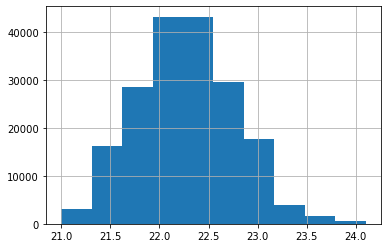

In [19]:
device_1['temp'].hist()

<AxesSubplot:>

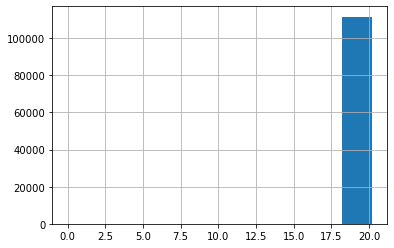

In [20]:
device_2['temp'].hist()

<AxesSubplot:>

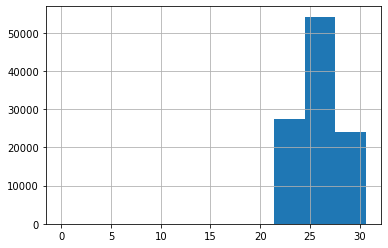

In [21]:
device_3['temp'].hist()

In [22]:
df_num = df.select_dtypes(include=[np.number])
df_num

,co,humidity,lpg,smoke,temp,hour,minute,second,microsecond,device_code
0,0.004956,51.000000,0.007651,0.020411,22.700000,0,1,34,385974,0
1,0.002840,76.000000,0.005114,0.013275,19.700001,0,1,34,735567,1
2,0.004976,50.900000,0.007673,0.020475,22.600000,0,1,38,73572,0
3,0.004403,76.800003,0.007023,0.018628,27.000000,0,1,39,589145,2
4,0.004967,50.900000,0.007664,0.020448,22.600000,0,1,41,761234,0
...,...,...,...,...,...,...,...,...,...,...
405179,0.003745,75.300003,0.006247,0.016437,19.200001,0,3,33,162014,1
405180,0.005882,48.500000,0.008660,0.023301,22.200000,0,3,33,576560,0
405181,0.004540,75.699997,0.007181,0.019076,26.600000,0,3,36,167959,2
405182,0.003745,75.300003,0.006247,0.016437,19.200001,0,3,36,979521,1


Text(0.5, 0.98, 'scatter_matrix_plot - all devices')

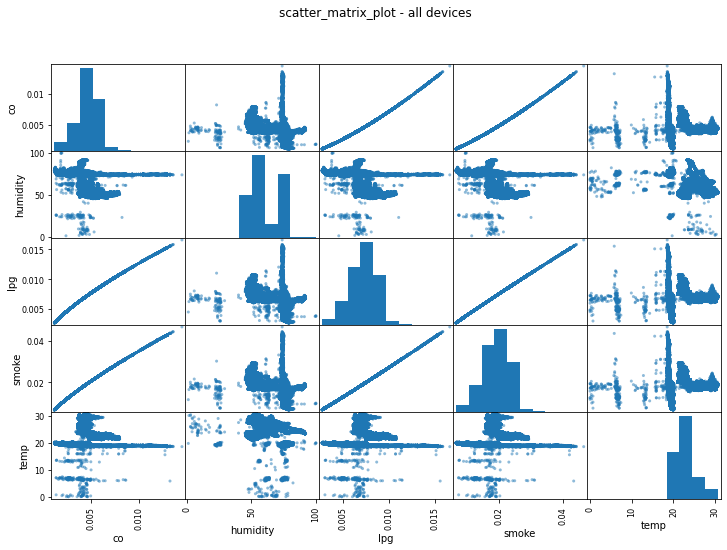

In [23]:
attributes = ['co', 'humidity', 'lpg', 'smoke', 'temp']
scatter_matrix(df_num[attributes],
               figsize=(12, 8))
plt.suptitle("scatter_matrix_plot - all devices")

Text(0.5, 0.98, 'scatter_matrix_plot - device code 2')

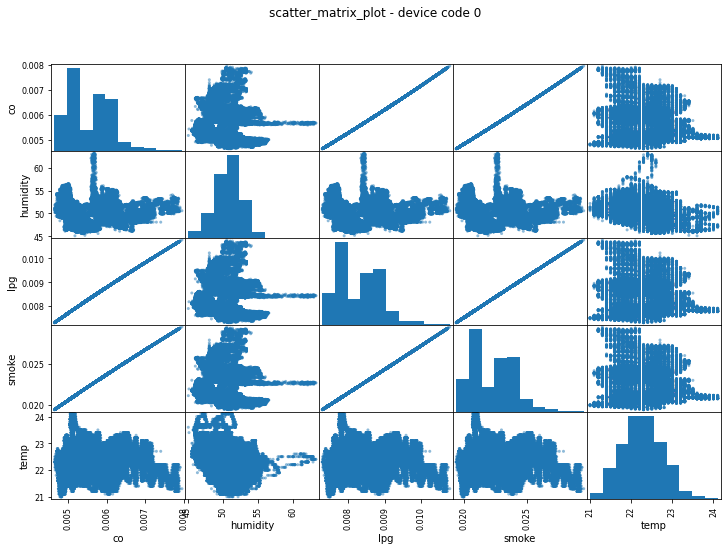

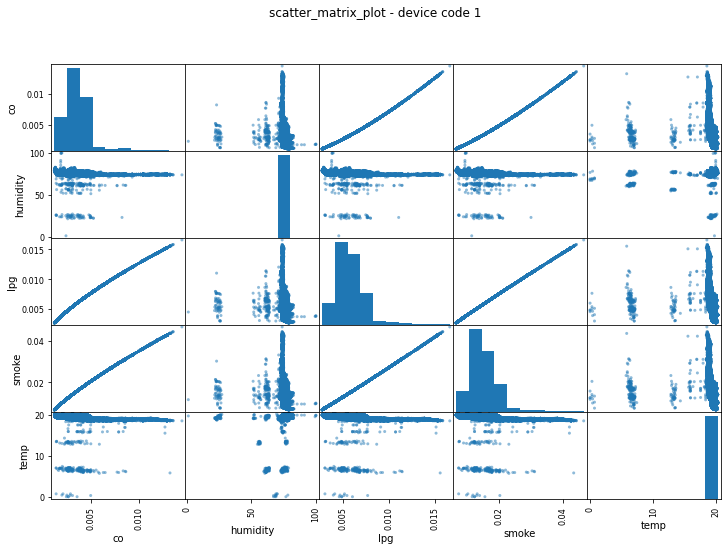

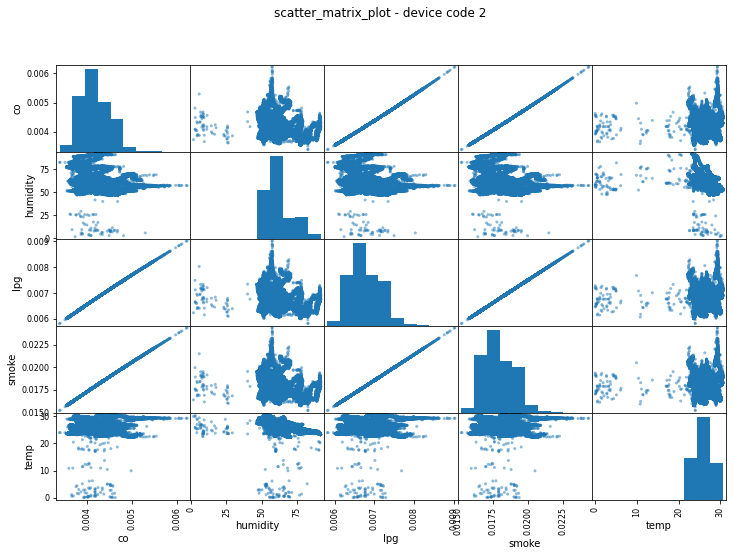

In [24]:
attributes = ['co', 'humidity', 'lpg', 'smoke', 'temp']
scatter_matrix(df_num[df_num['device_code']==0][attributes],
               figsize=(12, 8))
plt.suptitle("scatter_matrix_plot - device code 0")

scatter_matrix(df_num[df_num['device_code']==1][attributes],
               figsize=(12, 8))
plt.suptitle("scatter_matrix_plot - device code 1")

scatter_matrix(df_num[df_num['device_code']==2][attributes],
               figsize=(12, 8))
plt.suptitle("scatter_matrix_plot - device code 2")

In [25]:
corr_matrix = df[attributes].corr()
corr_matrix

,co,humidity,lpg,smoke,temp
co,1.000000,-0.656750,0.997331,0.998192,0.110905
humidity,-0.656750,1.000000,-0.672113,-0.669863,-0.410427
lpg,0.997331,-0.672113,1.000000,0.999916,0.136396
smoke,0.998192,-0.669863,0.999916,1.000000,0.131891
temp,0.110905,-0.410427,0.136396,0.131891,1.000000


In [26]:
corr_matrix["smoke"].sort_values(ascending=False)

smoke       1.000000
lpg         0.999916
co          0.998192
temp        0.131891
humidity   -0.669863
Name: smoke, dtype: float64

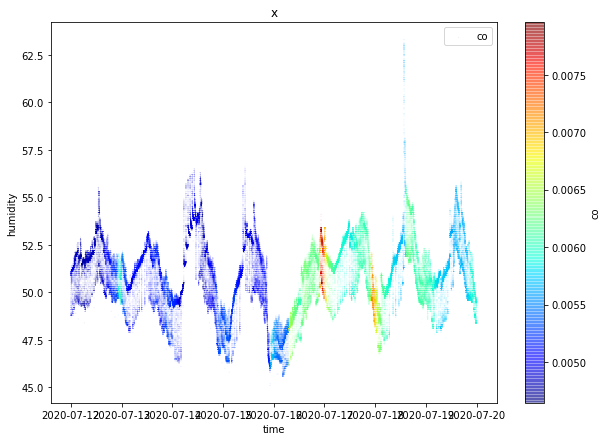

In [27]:
device_1.plot(kind="scatter",
               x="time", y="humidity",
               alpha=0.4, s=device_1["co"],
               label="co", figsize=(10,7),
               c="co", cmap=plt.get_cmap("jet"),
               colorbar=True, sharex=False,
               title="x")
plt.legend()
plt.show()

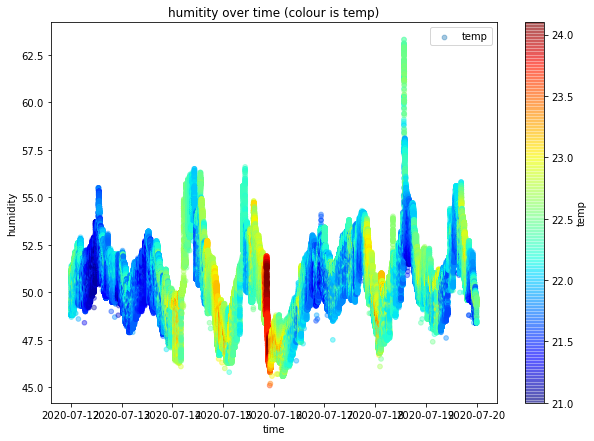

In [28]:
device_1.plot(kind="scatter",
               x="time", y="humidity",
               alpha=0.4, s=device_1["temp"],
               label="temp", figsize=(10,7),
               c="temp", cmap=plt.get_cmap("jet"),
               colorbar=True, sharex=False,
               title="humitity over time (colour is temp)")
plt.legend()
plt.show()

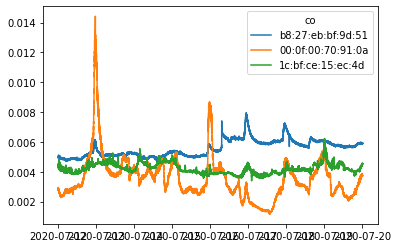

In [29]:
attribute = 'co'
plt.plot(device_1['time'], device_1[attribute], label=device_names[0])
plt.plot(device_2['time'], device_2[attribute], label=device_names[1])
plt.plot(device_3['time'], device_3[attribute], label=device_names[2])
plt.legend(title = attribute)
plt.show()

In [30]:
groups = df.groupby('device')

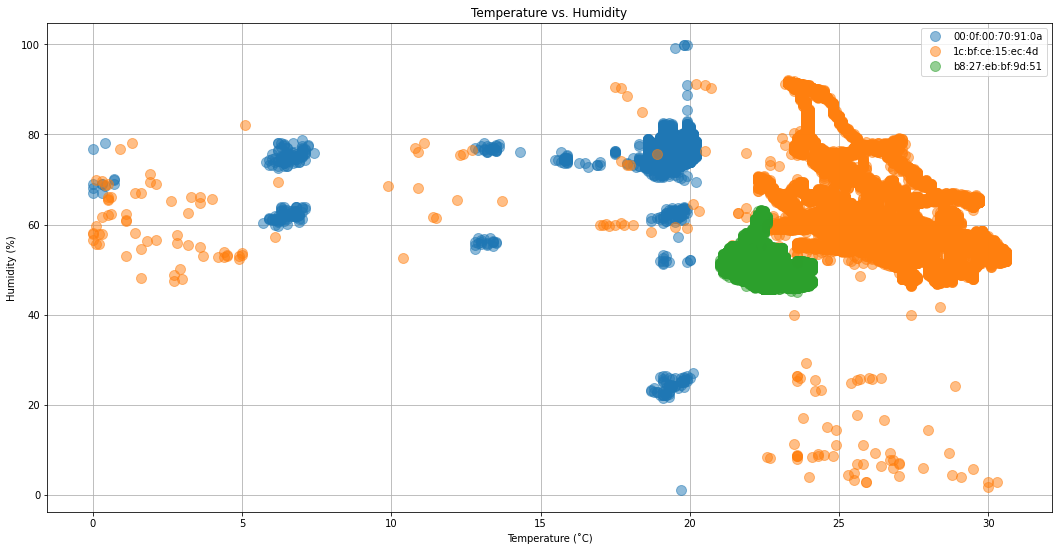

In [31]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    ax.plot(group.temp, group.humidity,
            marker='o', linestyle='',
            alpha=.5, ms=10,
            label=device)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature vs. Humidity')
plt.xlabel('Temperature (˚C)')
plt.ylabel('Humidity (%)')
plt.show()

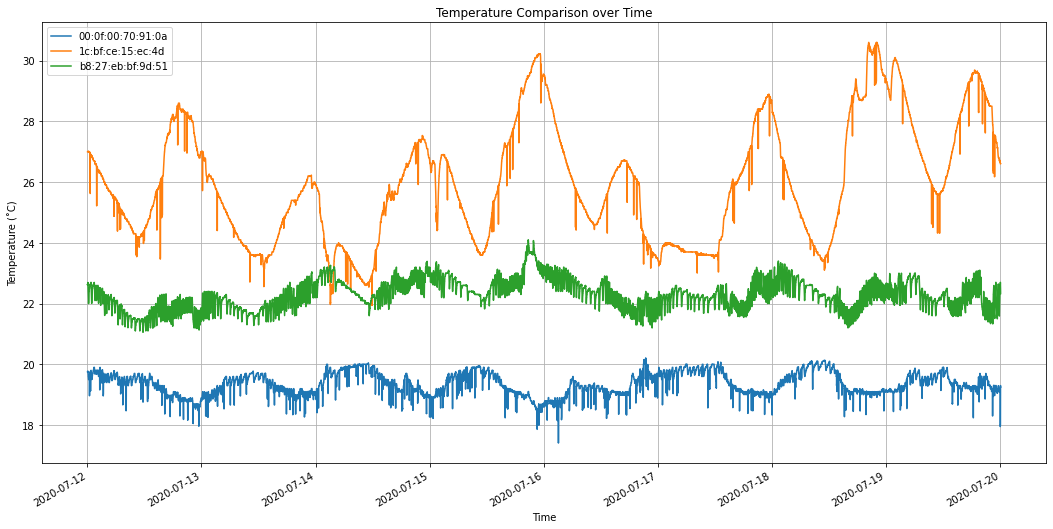

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group.mean = group.temp.rolling(window=20).mean()
    ax.plot(group.ts, group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature Comparison over Time')
plt.ylabel('Temperature (˚C)')
plt.xlabel('Time')
plt.show()

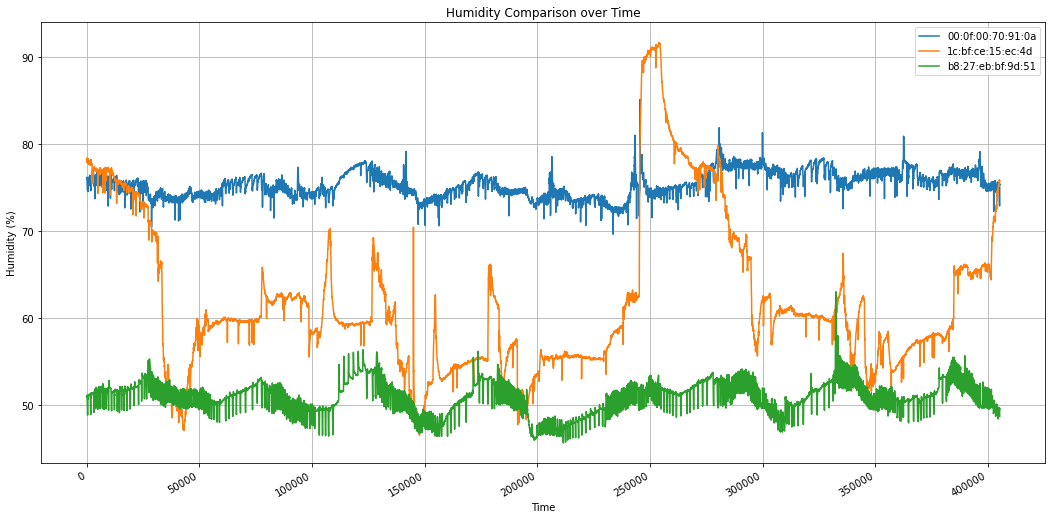

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group.mean = group.humidity.rolling(window=20).mean()
    ax.plot(group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Humidity Comparison over Time')
plt.ylabel('Humidity (%)')
plt.xlabel('Time')
plt.show()

### 3. Clean NULL-Values and Prepare for Machine Learning

In [34]:
df.isnull().any()

ts             False
device         False
co             False
humidity       False
light          False
lpg            False
motion         False
smoke          False
temp           False
time           False
hour           False
minute         False
second         False
microsecond    False
device_code    False
dtype: bool

### S. Split Training Data and Test Data

In [35]:
df_with_id = df.reset_index()

In [36]:
df_with_id.head()

,index,ts,device,co,humidity,light,lpg,motion,smoke,temp,time,hour,minute,second,microsecond,device_code
0,0,2020-07-12 00:01:34.385974646+00:00,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,2020-07-12 00:01:34.385974646+00:00,0,1,34,385974,0
1,1,2020-07-12 00:01:34.735567570+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2020-07-12 00:01:34.735567570+00:00,0,1,34,735567,1
2,2,2020-07-12 00:01:38.073572874+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,2020-07-12 00:01:38.073572874+00:00,0,1,38,73572,0
3,3,2020-07-12 00:01:39.589145899+00:00,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,2020-07-12 00:01:39.589145899+00:00,0,1,39,589145,2
4,4,2020-07-12 00:01:41.761234999+00:00,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,2020-07-12 00:01:41.761234999+00:00,0,1,41,761234,0


In [37]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [38]:
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "index")

In [39]:
print("train set: {0:7d}\ntest set : {1:7d}".format(len(train_set),len(test_set)))

train set:  323084
test set :   82100


<function matplotlib.pyplot.show(close=None, block=None)>

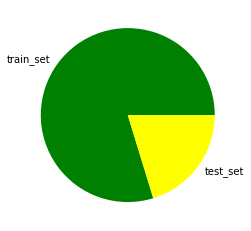

In [40]:
fig, axs = plt.subplots()
axs.pie([len(train_set), len(test_set)],
labels=['train_set', 'test_set'],
colors = ['green', 'yellow'])
plt.show

### I want to predict the `smoke`:

In [41]:
myDataset = train_set.drop("smoke", axis=1) # drop labels for training set
myDataset_labels = train_set["smoke"].copy()

### 4. Model-Specific Preprocessing

In [42]:
myDataset

,index,ts,device,co,humidity,light,lpg,motion,temp,time,hour,minute,second,microsecond,device_code
0,0,2020-07-12 00:01:34.385974646+00:00,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,22.700000,2020-07-12 00:01:34.385974646+00:00,0,1,34,385974,0
1,1,2020-07-12 00:01:34.735567570+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,19.700001,2020-07-12 00:01:34.735567570+00:00,0,1,34,735567,1
2,2,2020-07-12 00:01:38.073572874+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,22.600000,2020-07-12 00:01:38.073572874+00:00,0,1,38,73572,0
3,3,2020-07-12 00:01:39.589145899+00:00,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,27.000000,2020-07-12 00:01:39.589145899+00:00,0,1,39,589145,2
6,6,2020-07-12 00:01:45.448863745+00:00,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,22.600000,2020-07-12 00:01:45.448863745+00:00,0,1,45,448863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405178,405178,2020-07-20 00:03:30.755703926+00:00,1c:bf:ce:15:ec:4d,0.004553,75.800003,True,0.007196,False,26.600000,2020-07-20 00:03:30.755703926+00:00,0,3,30,755703,2
405179,405179,2020-07-20 00:03:33.162014961+00:00,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,19.200001,2020-07-20 00:03:33.162014961+00:00,0,3,33,162014,1
405180,405180,2020-07-20 00:03:33.576560736+00:00,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,22.200000,2020-07-20 00:03:33.576560736+00:00,0,3,33,576560,0
405181,405181,2020-07-20 00:03:36.167959213+00:00,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,26.600000,2020-07-20 00:03:36.167959213+00:00,0,3,36,167959,2


In [43]:
myDataset_cat = myDataset[['light', 'motion']]

In [44]:
cat_encoder = OneHotEncoder()

In [45]:
myDataset_cat_1hot = cat_encoder.fit_transform(myDataset_cat)

In [46]:
print("\ncat_encoder.categories_:\n", cat_encoder.categories_)
print("\nmyDataset_cat_1hot.toarray():\n", myDataset_cat_1hot.toarray())
print("\nmyDataset_cat_1hot:\n", myDataset_cat_1hot)


cat_encoder.categories_:
 [array([False,  True]), array([False,  True])]

myDataset_cat_1hot.toarray():
 [[1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 ...
 [1. 0. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 1. 0.]]

myDataset_cat_1hot:
   (0, 0)	1.0
  (0, 2)	1.0
  (1, 0)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (2, 2)	1.0
  (3, 1)	1.0
  (3, 2)	1.0
  (4, 0)	1.0
  (4, 2)	1.0
  (5, 0)	1.0
  (5, 2)	1.0
  (6, 1)	1.0
  (6, 2)	1.0
  (7, 0)	1.0
  (7, 2)	1.0
  (8, 0)	1.0
  (8, 2)	1.0
  (9, 0)	1.0
  (9, 2)	1.0
  (10, 1)	1.0
  (10, 2)	1.0
  (11, 0)	1.0
  (11, 2)	1.0
  (12, 0)	1.0
  :	:
  (323071, 2)	1.0
  (323072, 1)	1.0
  (323072, 2)	1.0
  (323073, 0)	1.0
  (323073, 2)	1.0
  (323074, 0)	1.0
  (323074, 2)	1.0
  (323075, 1)	1.0
  (323075, 2)	1.0
  (323076, 0)	1.0
  (323076, 2)	1.0
  (323077, 0)	1.0
  (323077, 2)	1.0
  (323078, 0)	1.0
  (323078, 2)	1.0
  (323079, 1)	1.0
  (323079, 2)	1.0
  (323080, 0)	1.0
  (323080, 2)	1.0
  (323081, 0)	1.0
  (323081, 2)	1.0
  (323082, 1)	1.0
  (323082, 2)	1.0
  (323083, 0)	1.0
  (32308

### 5. Pipelines and Custom Transformer

In [47]:
myDataset_num = myDataset.select_dtypes(include=[np.number]) 

In [48]:
myDataset_num

,index,co,humidity,lpg,temp,hour,minute,second,microsecond,device_code
0,0,0.004956,51.000000,0.007651,22.700000,0,1,34,385974,0
1,1,0.002840,76.000000,0.005114,19.700001,0,1,34,735567,1
2,2,0.004976,50.900000,0.007673,22.600000,0,1,38,73572,0
3,3,0.004403,76.800003,0.007023,27.000000,0,1,39,589145,2
6,6,0.004976,50.900000,0.007673,22.600000,0,1,45,448863,0
...,...,...,...,...,...,...,...,...,...,...
405178,405178,0.004553,75.800003,0.007196,26.600000,0,3,30,755703,2
405179,405179,0.003745,75.300003,0.006247,19.200001,0,3,33,162014,1
405180,405180,0.005882,48.500000,0.008660,22.200000,0,3,33,576560,0
405181,405181,0.004540,75.699997,0.007181,26.600000,0,3,36,167959,2


In [49]:
humidity_ix, temp_ix = [
    list(myDataset_num.columns).index(col)
    for col in ("humidity", "temp")]

def add_extra_features(X):
    humidity_to_temp = X[:, humidity_ix] * X[:, temp_ix]
    return np.c_[X, humidity_to_temp]

attr_adder = FunctionTransformer(add_extra_features, validate=False)
myDataset_num_extra_attribs = attr_adder.fit_transform(myDataset_num.values)

In [50]:
myDataset_num_extra_attribs = pd.DataFrame(
    myDataset_num_extra_attribs,
    columns=list(myDataset_num.columns)+["humidity_to_temp"],
    index=myDataset_num.index)

In [51]:
myDataset_num_extra_attribs.head()

,index,co,humidity,lpg,temp,hour,minute,second,microsecond,device_code,humidity_to_temp
0,0.0,0.004956,51.000000,0.007651,22.700000,0.0,1.0,34.0,385974.0,0.0,1157.700000
1,1.0,0.002840,76.000000,0.005114,19.700001,0.0,1.0,34.0,735567.0,1.0,1497.200058
2,2.0,0.004976,50.900000,0.007673,22.600000,0.0,1.0,38.0,73572.0,0.0,1150.340000
3,3.0,0.004403,76.800003,0.007023,27.000000,0.0,1.0,39.0,589145.0,2.0,2073.600082
6,6.0,0.004976,50.900000,0.007673,22.600000,0.0,1.0,45.0,448863.0,0.0,1150.340000


In [52]:
imputer = SimpleImputer(strategy="median")
imputer.fit(myDataset_num)
X = imputer.transform(myDataset_num)
myDataset_num_tr = pd.DataFrame(X, columns=myDataset_num.columns,
                          index=myDataset_num.index)

In [53]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attr_adder', FunctionTransformer(add_extra_features, 
                                       validate=False)),
    ('std_scaler', StandardScaler())
])

In [54]:
myDataset_num_tr = num_pipeline.fit_transform(myDataset_num)

In [55]:
print("myDataset_num_tr\n", myDataset_num_tr)

myDataset_num_tr
 [[-1.73243458  0.25504173 -0.83644623 ... -0.39029299 -0.96648484
  -0.79798362]
 [-1.73242603 -1.44030338  1.36309243 ...  0.81855767  0.24257174
   0.63913945]
 [-1.73241748  0.27112597 -0.84524438 ... -1.47054164 -0.96648484
  -0.82913892]
 ...
 [ 1.73243076  0.99726745 -1.0564001  ...  0.26873054 -0.96648484
  -1.14086123]
 [ 1.73243931 -0.07786312  1.3366977  ... -1.14416271  1.45162831
   2.82517424]
 [ 1.73244786 -0.71553249  1.30150561 ...  1.66212135  0.24257174
   0.42139125]]


In [56]:
num_attribs = list(myDataset_num)
cat_attribs = ['light', 'motion']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
myDataset_prepared = full_pipeline.fit_transform(myDataset)
print("myDataset_prepared\n", myDataset_prepared)

myDataset_prepared
 [[-1.73243458  0.25504173 -0.83644623 ...  0.          1.
   0.        ]
 [-1.73242603 -1.44030338  1.36309243 ...  0.          1.
   0.        ]
 [-1.73241748  0.27112597 -0.84524438 ...  0.          1.
   0.        ]
 ...
 [ 1.73243076  0.99726745 -1.0564001  ...  0.          1.
   0.        ]
 [ 1.73243931 -0.07786312  1.3366977  ...  1.          1.
   0.        ]
 [ 1.73244786 -0.71553249  1.30150561 ...  0.          1.
   0.        ]]


### 6. Select and Train Model

Predictions:
 [0.02041199 0.01327677 0.02047581 0.01862661 0.02047585 0.01362944
 0.01843835 0.02045752 0.0204256  0.02046193]
Labels:
 [0.02041127012241292, 0.013274836704851536, 0.02047512557617824, 0.018628225377018803, 0.020475166204362245, 0.013627521132019194, 0.018439781902116818, 0.02045681960706413, 0.02042485815208522, 0.020461237669931027]
lin_rmse
 2.360997598161802e-06
mean of labels:
 0.019259929185881867
std deviation of labels:
 0.004081337284458108


<AxesSubplot:>

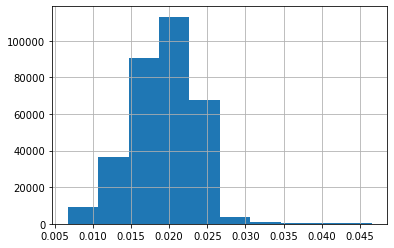

In [57]:
lin_reg = LinearRegression()
lin_reg.fit(myDataset_prepared, myDataset_labels)
some_data = myDataset.iloc[:10]
some_labels = myDataset_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\n", lin_reg.predict(some_data_prepared))
print("Labels:\n", list(some_labels)) # Compare against the actual values:

myDataset_predictions = lin_reg.predict(myDataset_prepared)
lin_mse = mean_squared_error(myDataset_labels, myDataset_predictions)
lin_rmse = np.sqrt(lin_mse)
print("lin_rmse\n", lin_rmse)

print("mean of labels:\n", myDataset_labels.mean())
print("std deviation of labels:\n", myDataset_labels.std())
myDataset_labels.hist()

In [58]:
myDataset_prepared.shape

(323084, 15)

`myDataset_prepared` has 15 columns. 

In [59]:
len(lin_reg.coef_)

15

`lin_re` has 15 coefficients (makes sense).  

In [60]:
lin_reg.coef_

array([ 5.28459676e-07,  7.24378009e-04, -6.14990292e-06,  3.35692784e-03,
       -3.23910807e-06, -1.39638269e-07,  3.48644858e-09, -4.15401305e-10,
        2.52178085e-09, -1.04337366e-06,  4.57978634e-06,  1.78993356e-07,
       -1.78993356e-07, -1.52184206e-07,  1.52184206e-07])

In [61]:
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [62]:
side_by_side = [(true, pred, (true-pred)/true)
                for true, pred in
                zip(list(myDataset_labels),
                    list(myDataset_predictions))]

In [63]:
side_by_side

[(0.02041127012241292, 0.020411986750433063, -3.5109428068233176e-05),
 (0.013274836704851536, 0.0132767722341164, -0.000145804374690122),
 (0.02047512557617824, 0.02047580532496512, -3.319876033730085e-05),
 (0.018628225377018803, 0.01862660804111124, 8.682179192226316e-05),
 (0.020475166204362245, 0.020475849034132663, -3.334916862711195e-05),
 (0.013627521132019194, 0.01362943986945548, -0.00014079871296456437),
 (0.018439781902116818, 0.018438346797972915, 7.782652482121331e-05),
 (0.02045681960706413, 0.020457518408481052, -3.415982691080013e-05),
 (0.02042485815208522, 0.02042559542837854, -3.609700923398918e-05),
 (0.020461237669931027, 0.02046193494584953, -3.407789547007225e-05),
 (0.018786490564423525, 0.01878467520580764, 9.663106633250284e-05),
 (0.020438716650667384, 0.020439435825351814, -3.5186880699104564e-05),
 (0.013508733329556249, 0.013510696672879977, -0.00014533881718074005),
 (0.020475033620232192, 0.020475721535708757, -3.359777030527275e-05),
 (0.02042485815208

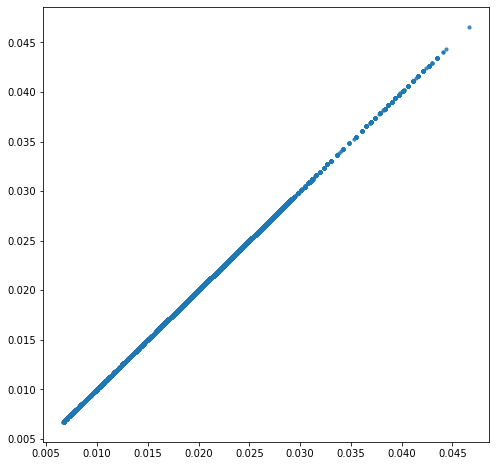

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
pts = ax.scatter(myDataset_predictions, myDataset_labels,
                 s=10, alpha=0.8)

### 7. Crossvalidation

In [65]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [66]:
lin_scores = cross_val_score(lin_reg, myDataset_prepared, 
                             myDataset_labels,
                             scoring="neg_mean_squared_error", 
                             cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1.53287642e-06 9.51991303e-06 1.46455476e-06 1.52936931e-06
 1.83678702e-06 1.97625216e-06 7.78682203e-06 2.08743980e-06
 1.55346421e-06 2.03505669e-06]
Mean: 3.1322535428254208e-06
Standard deviation: 2.796038107777333e-06


### 8. Save Model

In [67]:
joblib.dump(lin_reg, "myModel.pkl")

['myModel.pkl']

In [68]:
# und später...
my_model_loaded = joblib.load("myModel.pkl")

### 9. Optimize Model

In [69]:
param_grid = [
    {'fit_intercept': [True], 'n_jobs': [2, 4, 6, 8, 10]},    
    {'normalize': [True], 'n_jobs': [3, 10]},
  ]

lin_reg = LinearRegression()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
lin_grid_search = GridSearchCV(lin_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)
lin_grid_search.fit(myDataset_prepared, myDataset_labels)

print("Best Params: ", lin_grid_search.best_params_)
print("Best Estimator: ", lin_grid_search.best_estimator_)
print("\nResults (mean_test_score and params):")
cvres = lin_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
print("\nResults (complete):")
a = pd.DataFrame(lin_grid_search.cv_results_)
print(a)

Best Params:  {'n_jobs': 3, 'normalize': True}
Best Estimator:  LinearRegression(n_jobs=3, normalize=True)

Results (mean_test_score and params):
4.6970896327451035e-06 {'fit_intercept': True, 'n_jobs': 2}
4.6970896327451035e-06 {'fit_intercept': True, 'n_jobs': 4}
4.6970896327451035e-06 {'fit_intercept': True, 'n_jobs': 6}
4.6970896327451035e-06 {'fit_intercept': True, 'n_jobs': 8}
4.6970896327451035e-06 {'fit_intercept': True, 'n_jobs': 10}
4.69703564441106e-06 {'n_jobs': 3, 'normalize': True}
4.69703564441106e-06 {'n_jobs': 10, 'normalize': True}

Results (complete):
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.112999      0.007376         0.002601        0.000800   
1       0.139000      0.022272         0.003201        0.000400   
2       0.118599      0.007255         0.003001        0.000895   
3       0.128801      0.015639         0.002800        0.000748   
4       0.114000      0.006325         0.002601        0.000799   
5       0.131799     

### 10. Evaluate Final Model on Test Dataset

In [70]:
final_model = lin_grid_search.best_estimator_
print("final_model:\n", final_model)

X_test = test_set.drop("smoke", axis=1)
y_test = test_set["smoke"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print ("final_predictions:\n", final_predictions )
print ("final_rmse:\n", final_rmse )

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

print("95% confidence interval: ", 
      np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))
      )

final_model:
 LinearRegression(n_jobs=3, normalize=True)
final_predictions:
 [0.02044834 0.01858731 0.01856129 ... 0.02330144 0.02335931 0.02339997]
final_rmse:
 2.4077270093613086e-06
95% confidence interval:  [2.34309010e-06 2.47067349e-06]


In [71]:
side_by_side = [(true, pred, (true-pred)/true)
                for true, pred in
                zip(list(y_test),
                    list(final_predictions))]

In [72]:
side_by_side

[(0.020447620810233658, 0.020448338240385056, -3.508624098891997e-05),
 (0.01858890754005078, 0.01858731359243393, 8.574724541592612e-05),
 (0.01856286248579153, 0.018561292439699173, 8.457995600410214e-05),
 (0.013627521132019194, 0.013629470020532608, -0.00014301122665916557),
 (0.013274836704851536, 0.013276766985654831, -0.00014540900548999113),
 (0.020276445922912403, 0.02027733251452446, -4.372519796749288e-05),
 (0.020470443763956046, 0.020471110939979553, -3.259216220228476e-05),
 (0.02045691146558556, 0.020457599312067032, -3.3624160843052725e-05),
 (0.013391176782176004, 0.013393133878707886, -0.00014614821114801048),
 (0.02051615061031494, 0.020516790449619293, -3.118710310257787e-05),
 (0.01847852957469661, 0.018477044999599457, 8.0340542852843e-05),
 (0.013274836704851536, 0.013276796787977219, -0.000147654029142659),
 (0.013420557892696307, 0.013422496616840363, -0.00014445928101919738),
 (0.02035272400878184, 0.020353514701128006, -3.884946043713124e-05),
 (0.02043871665

In [73]:
final_predictions_df = pd.DataFrame(final_predictions, columns=["final_predictions"])
final_predictions_df

,final_predictions
0,0.020448
1,0.018587
2,0.018561
3,0.013629
4,0.013277
...,...
82095,0.023261
82096,0.023423
82097,0.023301
82098,0.023359


In [74]:
final_predictions

array([0.02044834, 0.01858731, 0.01856129, ..., 0.02330144, 0.02335931,
       0.02339997])

In [75]:
test_set.insert(loc=9, column="final_prediction", value=final_predictions)
#test_set = test_set.drop("final_prediction", axis=1)

In [82]:
test_set['abs_predicion_error'] = test_set['smoke'] - test_set['final_prediction']
test_set['rel_predicion_error'] = (test_set['smoke'] - test_set['final_prediction']) / test_set['smoke']

In [83]:
test_set.head(100)

,index,ts,device,co,humidity,light,lpg,motion,smoke,final_prediction,temp,time,hour,minute,second,microsecond,device_code,abs_predicion_error,rel_predicion_error
4,4,2020-07-12 00:01:41.761234999+00:00,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,0.020448,22.600000,2020-07-12 00:01:41.761234999+00:00,0,1,41,761234,0,-7.174302e-07,-0.000035
5,5,2020-07-12 00:01:44.468410730+00:00,1c:bf:ce:15:ec:4d,0.004391,77.900002,True,0.007009,False,0.018589,0.018587,27.000000,2020-07-12 00:01:44.468410730+00:00,0,1,44,468410,2,1.593948e-06,0.000086
11,11,2020-07-12 00:01:55.288542271+00:00,1c:bf:ce:15:ec:4d,0.004383,78.000000,True,0.007000,False,0.018563,0.018561,27.000000,2020-07-12 00:01:55.288542271+00:00,0,1,55,288542,2,1.570046e-06,0.000085
20,20,2020-07-12 00:02:11.476376534+00:00,00:0f:00:70:91:0a,0.002938,75.800003,False,0.005241,False,0.013628,0.013629,19.700001,2020-07-12 00:02:11.476376534+00:00,0,2,11,476376,1,-1.948889e-06,-0.000143
23,23,2020-07-12 00:02:15.289086342+00:00,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,0.013277,19.700001,2020-07-12 00:02:15.289086342+00:00,0,2,15,289086,1,-1.930281e-06,-0.000145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,498,2020-07-12 00:15:32.111268044+00:00,b8:27:eb:bf:9d:51,0.004995,49.400000,False,0.007694,False,0.020534,0.020535,22.000000,2020-07-12 00:15:32.111268044+00:00,0,15,32,111268,0,-9.260042e-07,-0.000045
523,523,2020-07-12 00:16:20.029010534+00:00,b8:27:eb:bf:9d:51,0.005021,50.100000,False,0.007723,False,0.020617,0.020618,22.000000,2020-07-12 00:16:20.029010534+00:00,0,16,20,29010,0,-7.617920e-07,-0.000037
526,526,2020-07-12 00:16:27.379077673+00:00,b8:27:eb:bf:9d:51,0.005021,50.200000,False,0.007723,False,0.020617,0.020618,22.000000,2020-07-12 00:16:27.379077673+00:00,0,16,27,379077,0,-7.527556e-07,-0.000037
535,535,2020-07-12 00:16:40.457407951+00:00,00:0f:00:70:91:0a,0.002840,75.199997,False,0.005114,False,0.013275,0.013277,19.500000,2020-07-12 00:16:40.457407951+00:00,0,16,40,457407,1,-2.015962e-06,-0.000152


In [84]:
test_set.to_csv(os.path.join("", "predictions.csv"), index=None, header=True)